In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from anm.gaze_dataloader.dataset import _create_senteces_from_data
from anm.attn_correlation.utils import *
import pandas as pd

### Script parameters
- Language: supported 'it' and 'en'
- Model name: the model to use
- Rollout: if to apply rollout to ValueZeroing
- Aggregation method: how to compute the attention of a word composed of multiple sub-tokens. Supported values:
	- sum: sum attention values of all sub-tokens
	- max: take the maximum attention value among sub-tokens
	- mean: average the attention values of the sub-tokens
	- first: take the attention value of the first sub-token
- Layer: the layer from which to extract attention

In [2]:
language = 'it'
rollout = True
aggregation_method = 'first'
layer = 11
model_name = 'xlm-roberta-base'
subword_prefix = '▁' #'Ġ' 
method = 'attention'

In [3]:
out_dir = f'output/attn_data/value_zeroing/{language}/{model_name}'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

out_file_name = f'{aggregation_method}' if not rollout else f'{aggregation_method}_rollout'
out_file_name += f'_l{layer}.json'
out_path = os.path.join(out_dir, out_file_name)
out_path

'output/attn_data/value_zeroing/it/xlm-roberta-base/first_rollout_l11.json'

In [4]:
dataset_path = '../augmenting_nlms_meco_data/en/en_49_dataset.csv'
data = pd.read_csv(dataset_path, index_col=0)
gaze_dataset = _create_senteces_from_data(data, [], keep_id=True)

In [5]:
gaze_dataset

Dataset({
    features: ['id', 'text'],
    num_rows: 47
})

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

Create a mapping of indices to align model's tokens and sub-tokens to original words

In [7]:
def align_to_original_words(model_tokens: list, original_tokens: list, subword_prefix: str,
                            lowercase: bool = False) -> list:
    if lowercase:
        original_tokens = [tok.lower() for tok in original_tokens]
    model_tokens = model_tokens[1: -1]  # Remove <s> and </s>
    aligned_model_tokens = []
    alignment_ids = []
    alignment_id = -1
    orig_idx = 0
    for token in model_tokens:
        alignment_id += 1
        if token.startswith(subword_prefix):  # Remove the sub-word prefix
            token = token[len(subword_prefix):]
        if len(aligned_model_tokens) == 0:  # First token (serve?)
            aligned_model_tokens.append(token)
        elif aligned_model_tokens[-1] + token in original_tokens[
            orig_idx]:  # We are in the second (third, fourth, ...) sub-token
            aligned_model_tokens[-1] += token  # so we merge the token with its preceding(s)
            alignment_id -= 1
        else:
            aligned_model_tokens.append(token)
        if aligned_model_tokens[-1] == original_tokens[
            orig_idx]:  # A token was equal to an entire original word or a set of
            orig_idx += 1  # sub-tokens was merged and matched an original word
        alignment_ids.append(alignment_id)

    if aligned_model_tokens != original_tokens:
        raise Exception(
            f'Failed to align tokens.\nOriginal tokens: {original_tokens}\nObtained alignment: {aligned_model_tokens}')
    return alignment_ids

In [8]:
def create_subwords_alignment(dataset: list, tokenizer: AutoTokenizer, subword_prefix: str,
                              lowercase: bool = False) -> dict:
    sentence_alignment_dict = dict()

    for sent_id, sentence in zip(dataset['id'], dataset['text']):
        for tok_id, tok in enumerate(sentence):
            if tok == '–':
                sentence[tok_id] = '-'
        if lowercase:
            sentence = [word.lower() for word in sentence]
        tokenized_sentence = tokenizer(sentence, is_split_into_words=True, return_tensors='pt')
        input_ids = tokenized_sentence['input_ids'].tolist()[0]  # 0 because the batch_size is 1
        model_tokens = tokenizer.convert_ids_to_tokens(input_ids)
        alignment_ids = align_to_original_words(model_tokens, sentence, subword_prefix, lowercase)
        sentence_alignment_dict[sent_id] = {'model_input': tokenized_sentence, 'alignment_ids': alignment_ids}
    return sentence_alignment_dict

In [9]:
sentence_alignment_dict = create_subwords_alignment(gaze_dataset, tokenizer, subword_prefix)

In [10]:
if method == 'valuezeroing':
    attn_extractor = ValueZeroingContributionExtractor(model_name, layer, rollout, aggregation_method, 'cpu')
elif method == 'alti':
    attn_extractor = AltiContributionExtractor(model_name, layer, rollout, aggregation_method, 'cpu')
else:
    attn_extractor = AttentionMatrixExtractor(model_name, layer, rollout, aggregation_method, 'cpu')

In [11]:
sentences_contribs = attn_extractor.get_contributions(sentence_alignment_dict)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 90.99it/s]


In [12]:
import matplotlib.pyplot as plt
def plot_contributions(tokens, contributions):
    plt.bar(tokens, contributions)
    plt.xticks(rotation=90)

In [14]:
sentence_id = gaze_dataset['id'][0]
sentence = gaze_dataset['text'][0]
contribs = sentences_contribs[sentence_id]

In [15]:
len(sentence_alignment_dict[sentence_id]['model_input']['input_ids'][0])

30

In [16]:
len(sentence), len(contribs)

(25, 25)

In [17]:
sentence

['The',
 'International',
 'Union',
 'for',
 'Conservation',
 'of',
 'Nature',
 'is',
 'an',
 'international',
 'organization',
 'working',
 'in',
 'the',
 'field',
 'of',
 'nature',
 'conservation',
 'and',
 'the',
 'sustainable',
 'use',
 'of',
 'natural',
 'resources.']

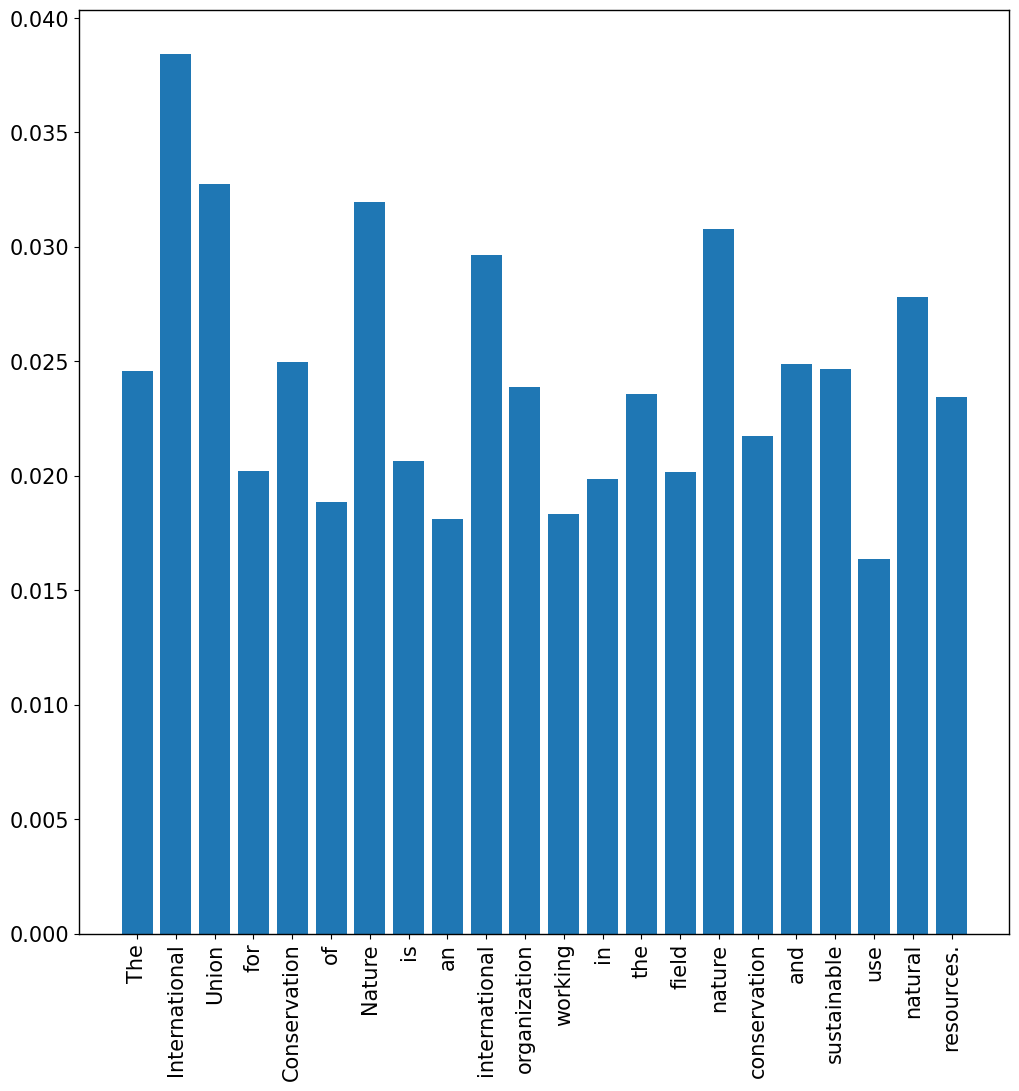

In [18]:
plot_contributions(sentence, contribs)